# 🌳 ML Workshop - Decision Trees & Boosting

**Author:** Shuvam Banerji Seal

This notebook covers:
- Decision Trees and how they work
- Information Gain, Entropy, and Gini Impurity
- Ensemble Methods: Bagging and Boosting
- Random Forest and Gradient Boosting
- XGBoost in practice

---

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

from sklearn.datasets import make_moons, make_classification, load_iris
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score, classification_report

try:
    import xgboost as xgb
    HAS_XGB = True
except ImportError:
    HAS_XGB = False
    print("XGBoost not installed. Some cells will be skipped.")

# Set style
plt.style.use('dark_background')
plt.rcParams['figure.figsize'] = (12, 8)

# Colors
CYAN = '#00d9ff'
PINK = '#ff6b9d'
YELLOW = '#c8ff00'
GREEN = '#00ff88'

np.random.seed(42)

## 1. Understanding Entropy and Information Gain

**Entropy** measures uncertainty:
$$H(S) = -\sum_{i=1}^{c} p_i \log_2(p_i)$$

**Information Gain** measures the reduction in entropy:
$$IG(S, A) = H(S) - \sum_{v \in Values(A)} \frac{|S_v|}{|S|} H(S_v)$$

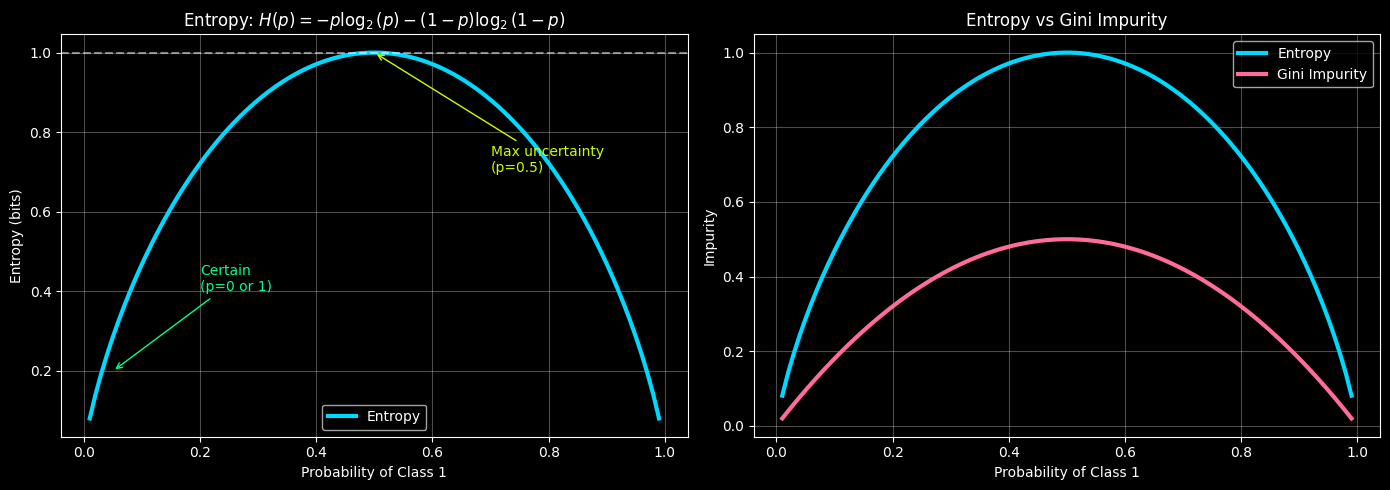


📊 Key Insight:
   - Both metrics measure 'impurity' of a node
   - Maximum impurity at p=0.5 (50-50 split)
   - Minimum impurity at p=0 or p=1 (pure node)
   - Gini is slightly faster to compute (no log)


In [2]:
def entropy(p):
    """Calculate entropy of a binary distribution."""
    if p == 0 or p == 1:
        return 0
    return -p * np.log2(p) - (1-p) * np.log2(1-p)

def gini(p):
    """Calculate Gini impurity of a binary distribution."""
    return 2 * p * (1 - p)

# Plot entropy and Gini
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

p = np.linspace(0.01, 0.99, 100)

# Entropy plot
ax1 = axes[0]
ax1.plot(p, [entropy(pi) for pi in p], color=CYAN, linewidth=3, label='Entropy')
ax1.axhline(y=1, color='white', linestyle='--', alpha=0.5)
ax1.set_xlabel('Probability of Class 1')
ax1.set_ylabel('Entropy (bits)')
ax1.set_title('Entropy: $H(p) = -p\\log_2(p) - (1-p)\\log_2(1-p)$')
ax1.grid(True, alpha=0.3)
ax1.legend()

# Add annotations
ax1.annotate('Max uncertainty\n(p=0.5)', xy=(0.5, 1), xytext=(0.7, 0.7),
            arrowprops=dict(arrowstyle='->', color=YELLOW), color=YELLOW)
ax1.annotate('Certain\n(p=0 or 1)', xy=(0.05, 0.2), xytext=(0.2, 0.4),
            arrowprops=dict(arrowstyle='->', color=GREEN), color=GREEN)

# Gini vs Entropy
ax2 = axes[1]
ax2.plot(p, [entropy(pi) for pi in p], color=CYAN, linewidth=3, label='Entropy')
ax2.plot(p, [gini(pi) for pi in p], color=PINK, linewidth=3, label='Gini Impurity')
ax2.set_xlabel('Probability of Class 1')
ax2.set_ylabel('Impurity')
ax2.set_title('Entropy vs Gini Impurity')
ax2.grid(True, alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.show()

print("\n📊 Key Insight:")
print("   - Both metrics measure 'impurity' of a node")
print("   - Maximum impurity at p=0.5 (50-50 split)")
print("   - Minimum impurity at p=0 or p=1 (pure node)")
print("   - Gini is slightly faster to compute (no log)")

## 2. Decision Tree Visualization

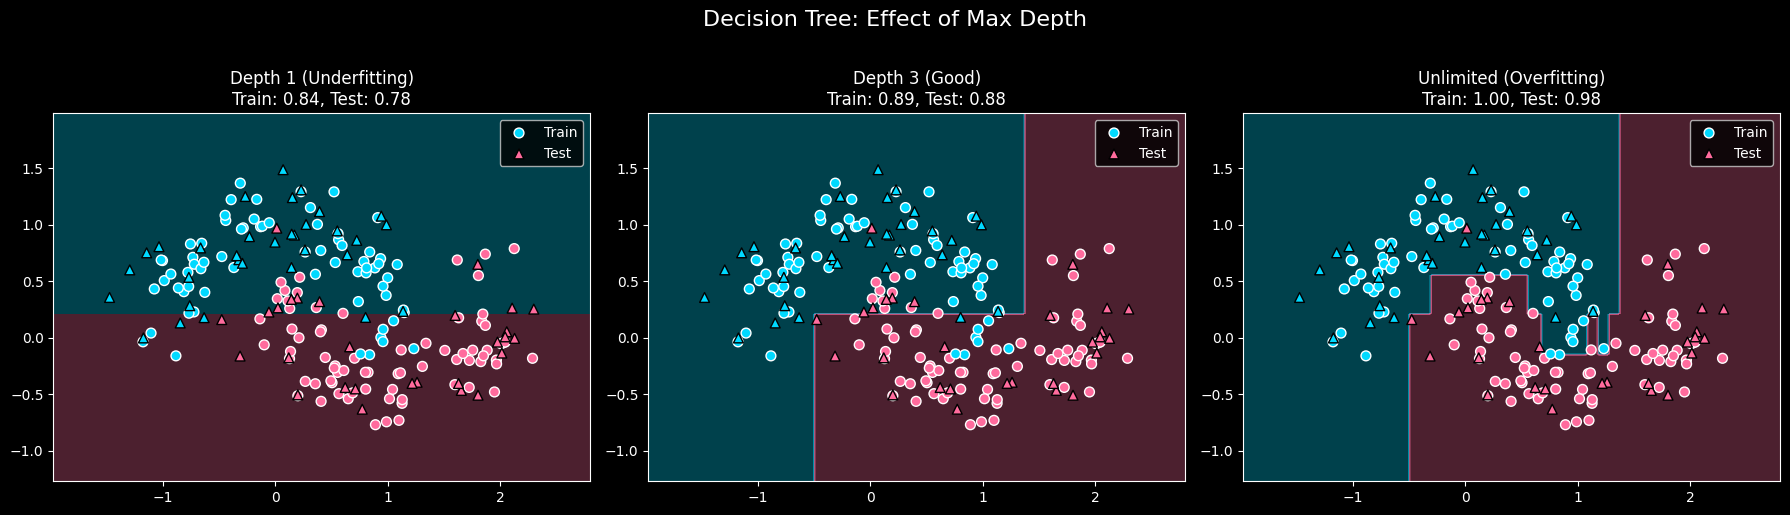

In [3]:
# Create a simple dataset
X, y = make_moons(n_samples=200, noise=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train decision trees with different depths
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

depths = [1, 3, None]  # None = unlimited depth
titles = ['Depth 1 (Underfitting)', 'Depth 3 (Good)', 'Unlimited (Overfitting)']

# Create mesh for plotting decision boundary
x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                     np.linspace(y_min, y_max, 200))

cmap = ListedColormap([CYAN, PINK])

for ax, depth, title in zip(axes, depths, titles):
    # Train model
    clf = DecisionTreeClassifier(max_depth=depth, random_state=42)
    clf.fit(X_train, y_train)
    
    train_acc = clf.score(X_train, y_train)
    test_acc = clf.score(X_test, y_test)
    
    # Plot decision boundary
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    ax.contourf(xx, yy, Z, alpha=0.3, cmap=cmap)
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cmap, 
               edgecolors='white', s=50, label='Train')
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cmap,
               edgecolors='black', s=50, marker='^', label='Test')
    
    ax.set_title(f"{title}\nTrain: {train_acc:.2f}, Test: {test_acc:.2f}")
    ax.legend()

plt.suptitle('Decision Tree: Effect of Max Depth', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

## 3. Visualize the Tree Structure

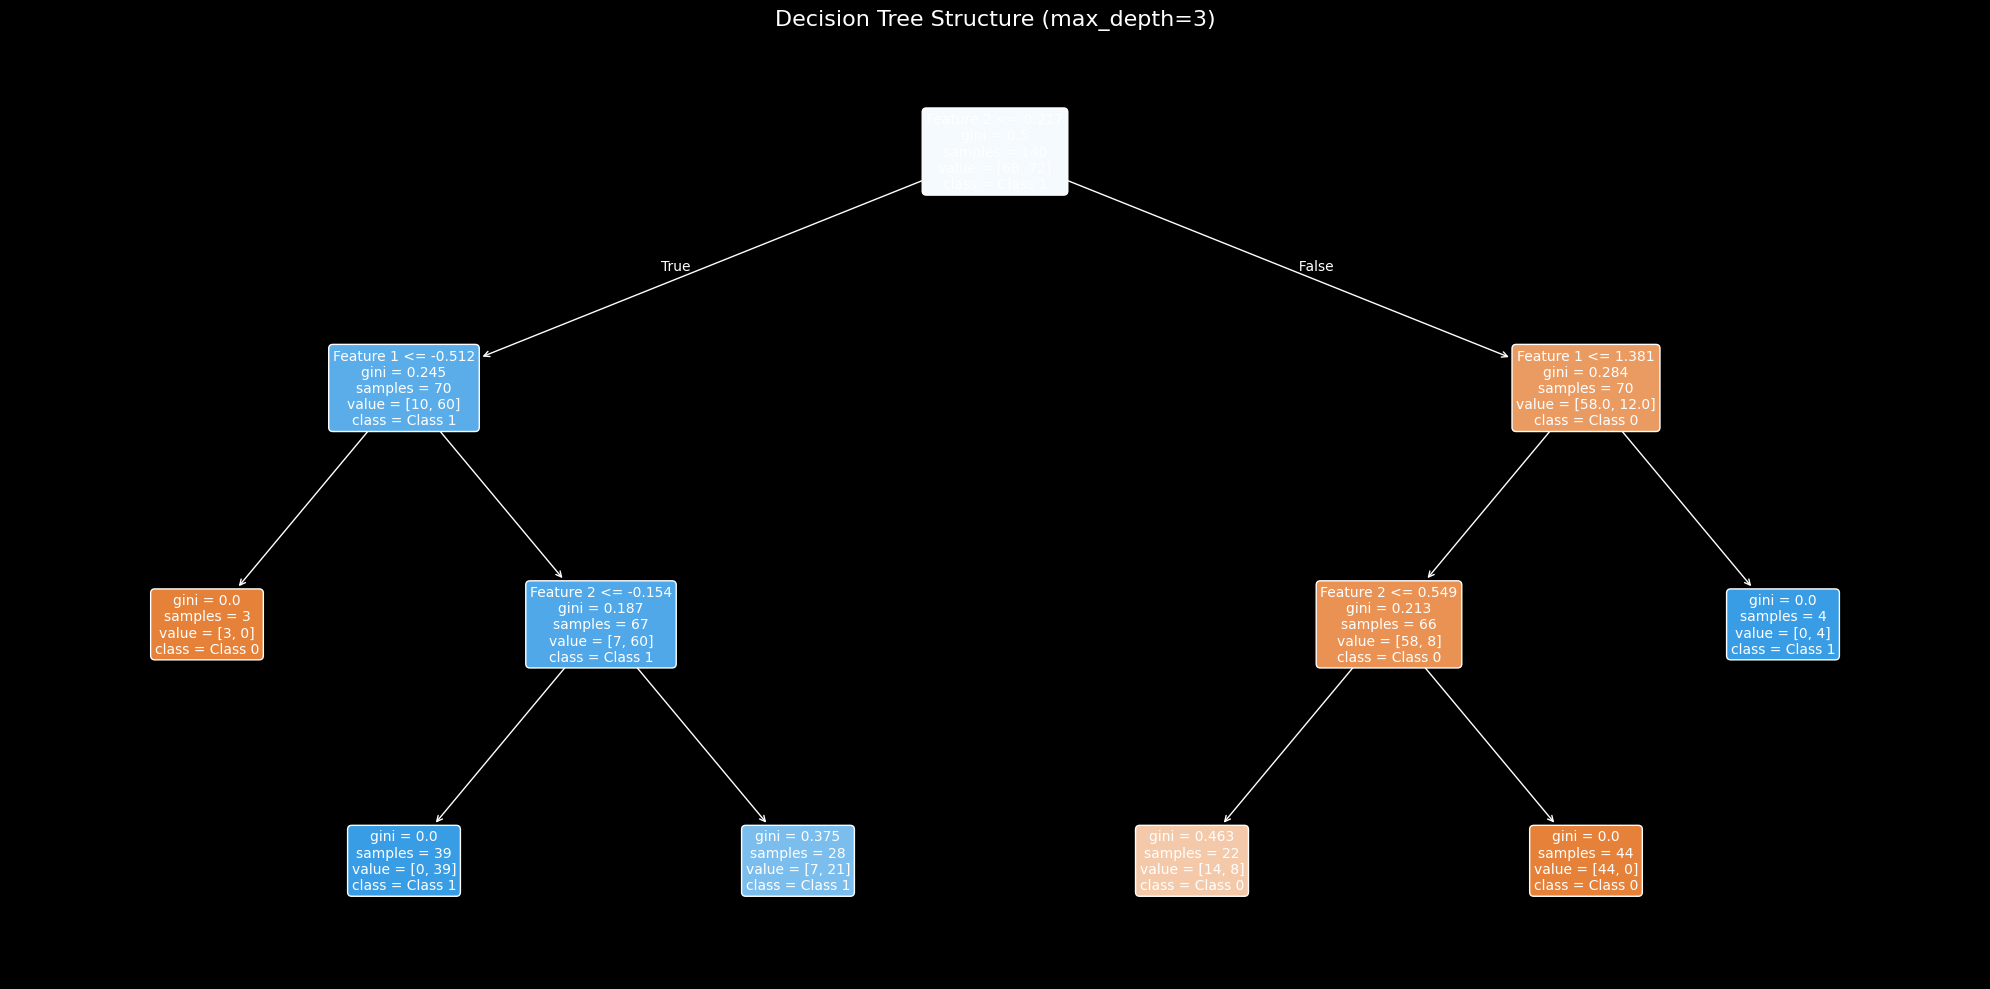

In [4]:
# Train a small tree for visualization
clf = DecisionTreeClassifier(max_depth=3, random_state=42)
clf.fit(X_train, y_train)

# Plot the tree
fig, ax = plt.subplots(figsize=(20, 10))
plot_tree(clf, 
          feature_names=['Feature 1', 'Feature 2'],
          class_names=['Class 0', 'Class 1'],
          filled=True,
          rounded=True,
          fontsize=10,
          ax=ax)
plt.title('Decision Tree Structure (max_depth=3)', fontsize=16)
plt.tight_layout()
plt.show()

## 4. Ensemble Methods: Bagging vs Boosting

**Bagging** (Bootstrap Aggregating):
- Train multiple models on random subsets of data
- Average predictions (reduces variance)
- Example: Random Forest

**Boosting**:
- Train models sequentially, focusing on errors
- Each model corrects the previous one
- Example: AdaBoost, Gradient Boosting, XGBoost

Decision Tree       : Train Acc = 0.9114, Test Acc = 0.8333
Random Forest       : Train Acc = 0.9700, Test Acc = 0.8900
AdaBoost            : Train Acc = 0.9314, Test Acc = 0.8267
Gradient Boosting   : Train Acc = 0.9957, Test Acc = 0.9067


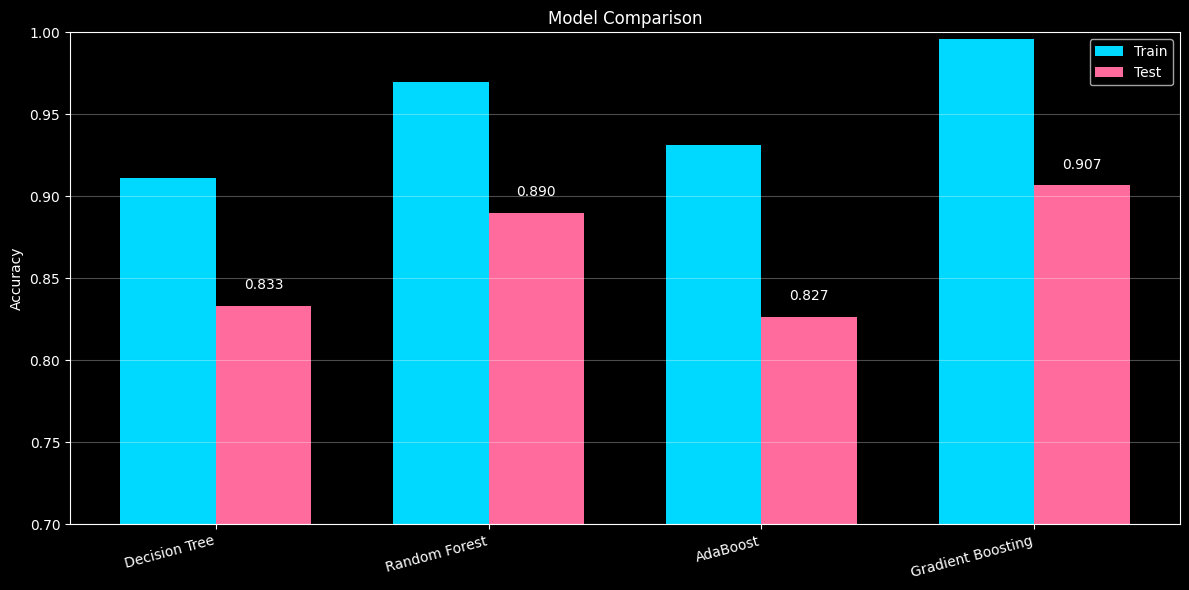

In [5]:
# Create a more complex dataset
X, y = make_classification(n_samples=1000, n_features=20, n_informative=10,
                          n_redundant=5, n_clusters_per_class=2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Define models
models = {
    'Decision Tree': DecisionTreeClassifier(max_depth=5, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42),
    'AdaBoost': AdaBoostClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, max_depth=3, random_state=42),
}

if HAS_XGB:
    models['XGBoost'] = xgb.XGBClassifier(n_estimators=100, max_depth=3, random_state=42, 
                                          use_label_encoder=False, eval_metric='logloss')

# Train and evaluate
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    train_acc = model.score(X_train, y_train)
    test_acc = model.score(X_test, y_test)
    results[name] = {'train': train_acc, 'test': test_acc}
    print(f"{name:20s}: Train Acc = {train_acc:.4f}, Test Acc = {test_acc:.4f}")

# Visualize results
fig, ax = plt.subplots(figsize=(12, 6))

x_pos = np.arange(len(results))
width = 0.35

train_accs = [r['train'] for r in results.values()]
test_accs = [r['test'] for r in results.values()]

bars1 = ax.bar(x_pos - width/2, train_accs, width, label='Train', color=CYAN)
bars2 = ax.bar(x_pos + width/2, test_accs, width, label='Test', color=PINK)

ax.set_ylabel('Accuracy')
ax.set_title('Model Comparison')
ax.set_xticks(x_pos)
ax.set_xticklabels(results.keys(), rotation=15, ha='right')
ax.legend()
ax.set_ylim([0.7, 1.0])
ax.grid(True, alpha=0.3, axis='y')

# Add value labels
for bar, val in zip(bars2, test_accs):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
            f'{val:.3f}', ha='center', fontsize=10)

plt.tight_layout()
plt.show()

## 5. Feature Importance

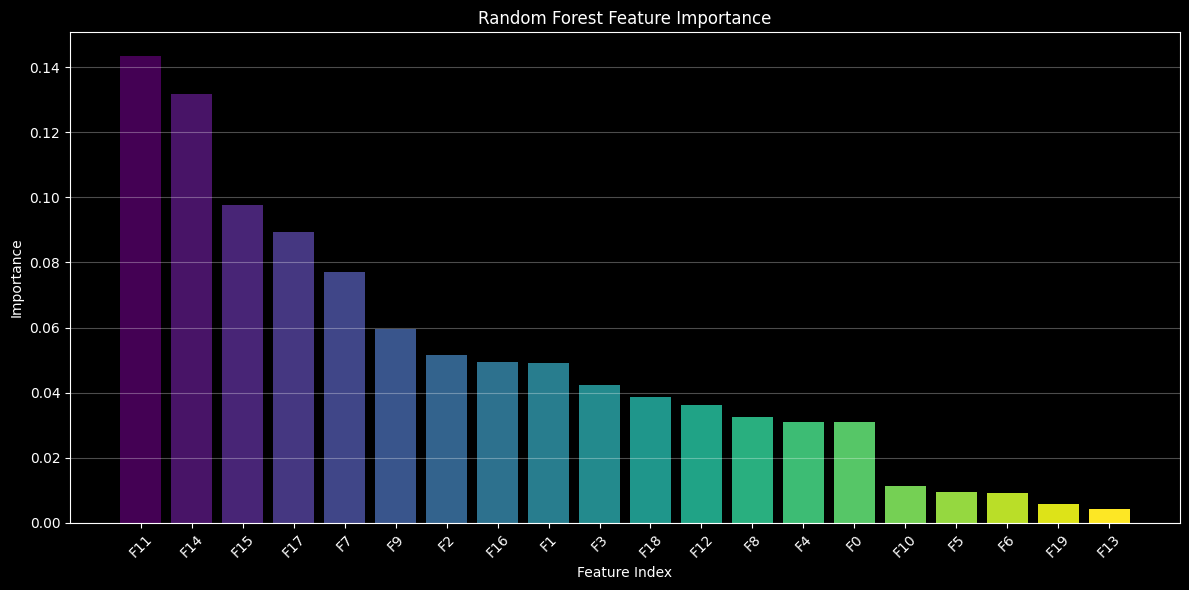


📊 Top 5 Most Important Features:
   Feature 11: 0.1436
   Feature 14: 0.1318
   Feature 15: 0.0976
   Feature 17: 0.0893
   Feature 7: 0.0770


In [6]:
# Get feature importance from Random Forest
rf = models['Random Forest']
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

# Plot feature importance
fig, ax = plt.subplots(figsize=(12, 6))

colors = plt.cm.viridis(np.linspace(0, 1, len(importances)))
ax.bar(range(len(importances)), importances[indices], color=colors)
ax.set_xlabel('Feature Index')
ax.set_ylabel('Importance')
ax.set_title('Random Forest Feature Importance')
ax.set_xticks(range(len(importances)))
ax.set_xticklabels([f'F{i}' for i in indices], rotation=45)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\n📊 Top 5 Most Important Features:")
for i in range(5):
    print(f"   Feature {indices[i]}: {importances[indices[i]]:.4f}")

## 6. Boosting: Learning from Mistakes

Visualize how boosting progressively improves!

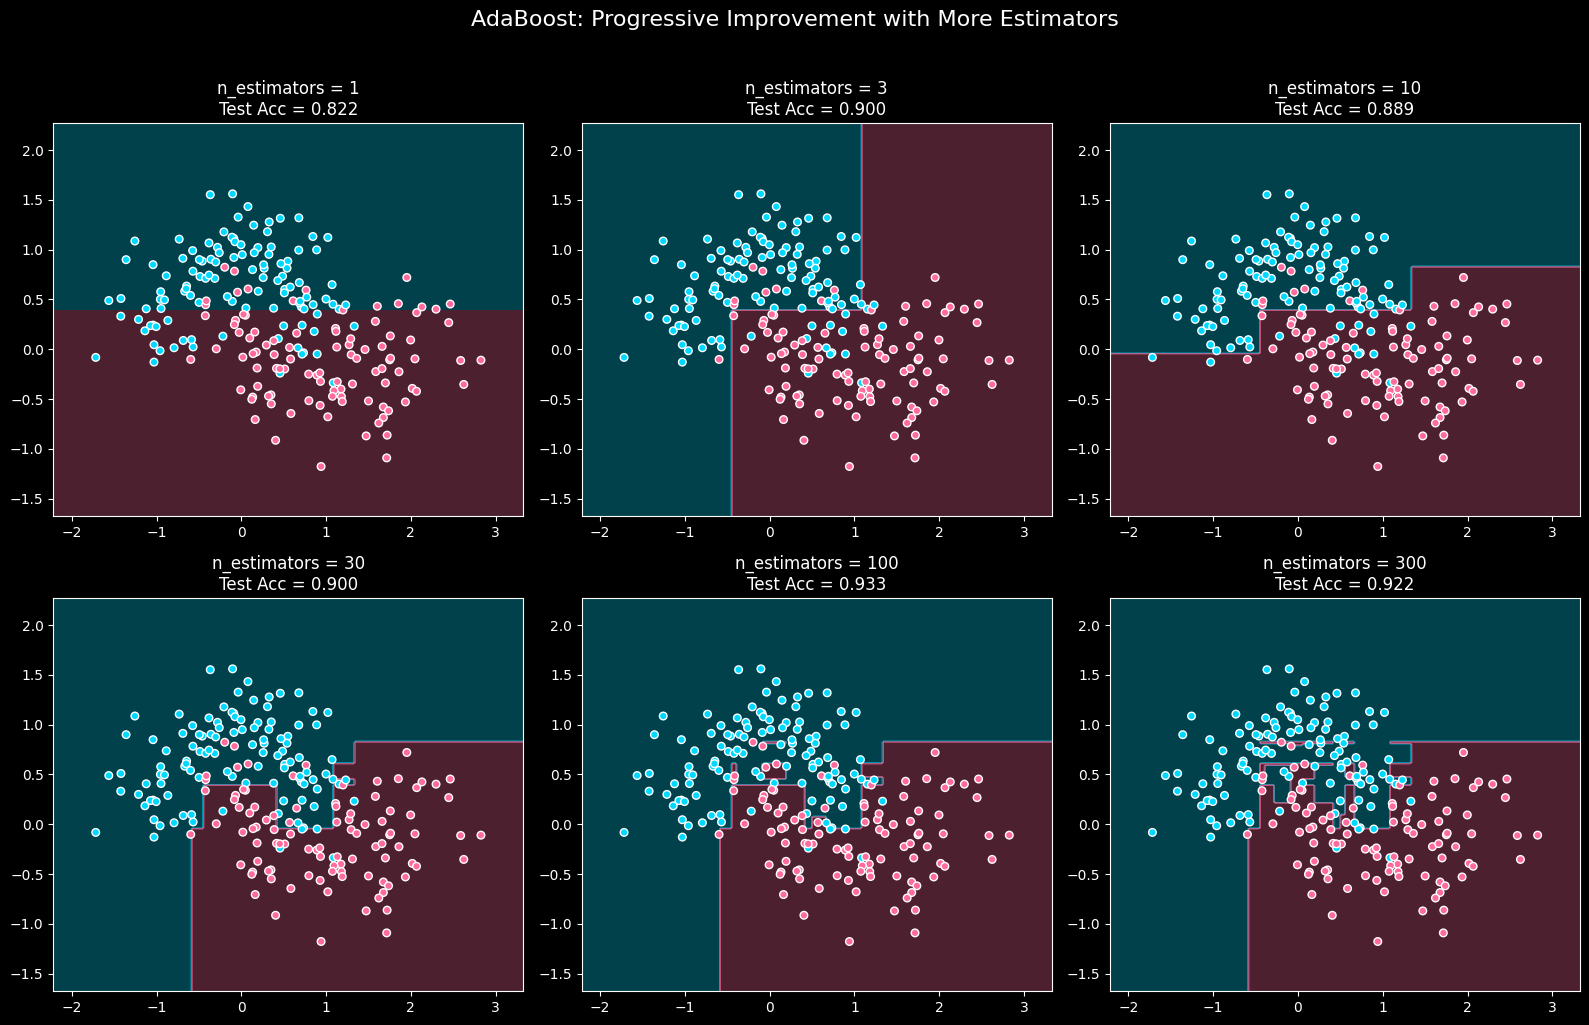

In [7]:
# Use moons dataset for visualization
X, y = make_moons(n_samples=300, noise=0.3, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Create mesh
x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                     np.linspace(y_min, y_max, 200))

# Train AdaBoost with different number of estimators
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

n_estimators_list = [1, 3, 10, 30, 100, 300]

for ax, n_est in zip(axes.flatten(), n_estimators_list):
    clf = AdaBoostClassifier(n_estimators=n_est, random_state=42)
    clf.fit(X_train, y_train)
    
    test_acc = clf.score(X_test, y_test)
    
    # Plot decision boundary
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    ax.contourf(xx, yy, Z, alpha=0.3, cmap=ListedColormap([CYAN, PINK]))
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, 
               cmap=ListedColormap([CYAN, PINK]), edgecolors='white', s=30)
    ax.set_title(f'n_estimators = {n_est}\nTest Acc = {test_acc:.3f}')

plt.suptitle('AdaBoost: Progressive Improvement with More Estimators', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

## 7. XGBoost: The Competition Winner

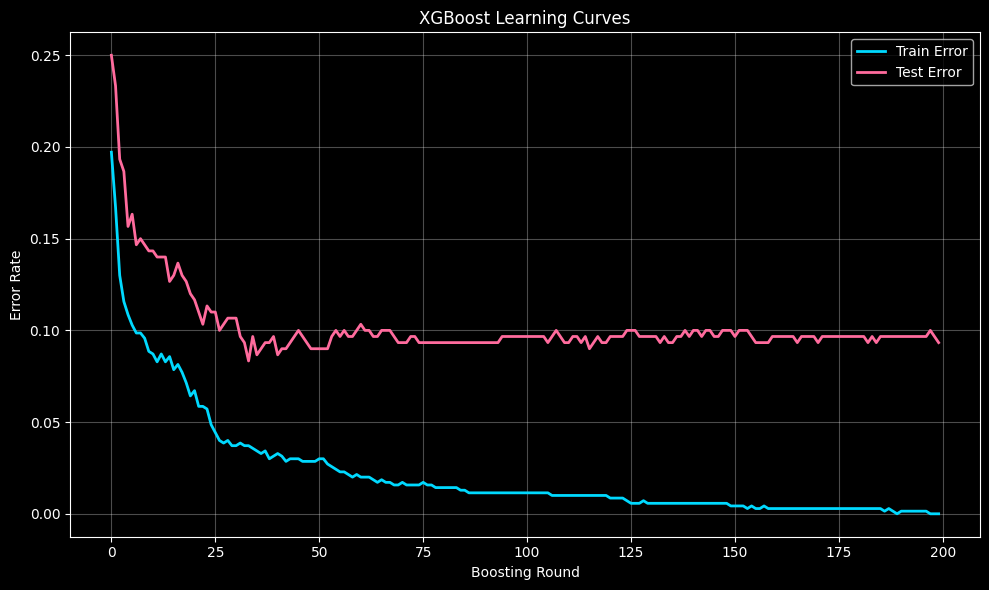


📊 Final Performance:
   Train Error: 0.0000 (Accuracy: 1.0000)
   Test Error:  0.0933 (Accuracy: 0.9067)


In [12]:
if HAS_XGB:
    # Reload complex dataset
    X, y = make_classification(n_samples=1000, n_features=20, n_informative=10,
                              n_redundant=5, random_state=42)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    # Create DMatrix for XGBoost
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)
    
    # Set parameters
    params = {
        'max_depth': 3,
        'eta': 0.1,
        'objective': 'binary:logistic',
        'eval_metric': 'error'
    }
    
    # Train with evaluation
    evallist = [(dtrain, 'train'), (dtest, 'test')]
    evals_result = {}
    
    model = xgb.train(
        params,
        dtrain,
        num_boost_round=200,
        evals=evallist,
        evals_result=evals_result,
        verbose_eval=False
    )
    
    # Plot learning curves
    fig, ax = plt.subplots(figsize=(10, 6))
    
    train_error = evals_result['train']['error']
    test_error = evals_result['test']['error']
    
    ax.plot(train_error, color=CYAN, label='Train Error', linewidth=2)
    ax.plot(test_error, color=PINK, label='Test Error', linewidth=2)
    ax.set_xlabel('Boosting Round')
    ax.set_ylabel('Error Rate')
    ax.set_title('XGBoost Learning Curves')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n📊 Final Performance:")
    print(f"   Train Error: {train_error[-1]:.4f} (Accuracy: {1-train_error[-1]:.4f})")
    print(f"   Test Error:  {test_error[-1]:.4f} (Accuracy: {1-test_error[-1]:.4f})")
else:
    print("XGBoost not available. Install with: pip install xgboost")

## 8. Hyperparameter Tuning Tips

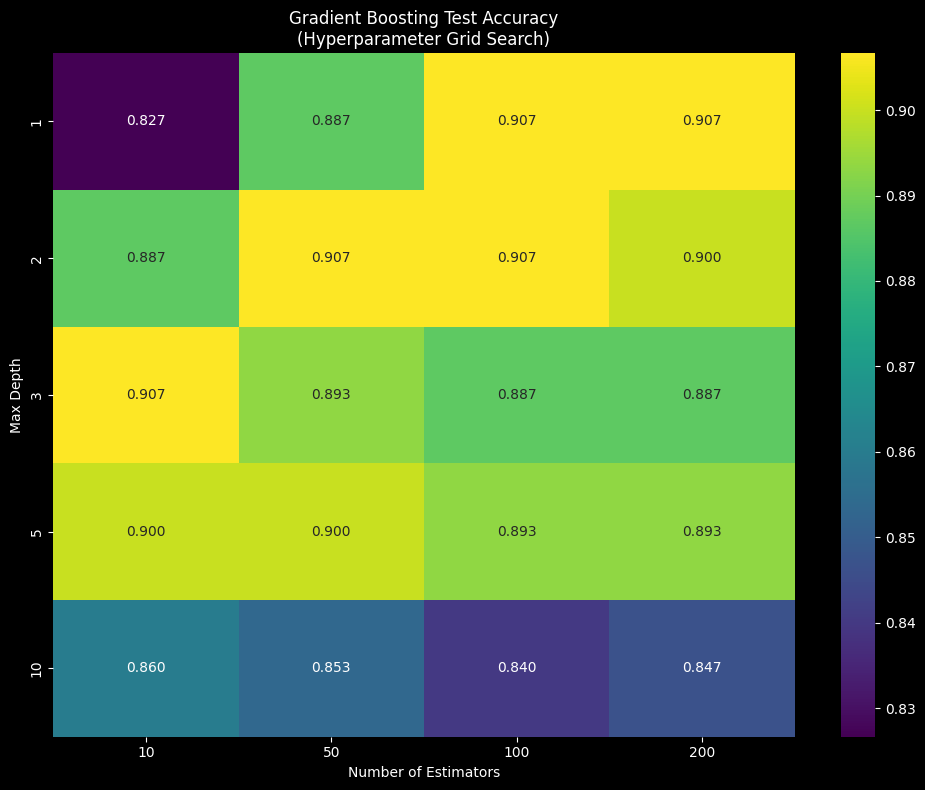


🏆 Best Configuration:
   Max Depth: 1
   N Estimators: 100
   Test Accuracy: 0.9067


In [13]:
# Demonstrate effect of max_depth and n_estimators
X, y = make_moons(n_samples=500, noise=0.3, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

depths = [1, 2, 3, 5, 10]
n_estimators = [10, 50, 100, 200]

results = np.zeros((len(depths), len(n_estimators)))

for i, depth in enumerate(depths):
    for j, n_est in enumerate(n_estimators):
        clf = GradientBoostingClassifier(max_depth=depth, n_estimators=n_est, random_state=42)
        clf.fit(X_train, y_train)
        results[i, j] = clf.score(X_test, y_test)

# Heatmap
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(results, annot=True, fmt='.3f', cmap='viridis',
            xticklabels=n_estimators, yticklabels=depths, ax=ax)
ax.set_xlabel('Number of Estimators')
ax.set_ylabel('Max Depth')
ax.set_title('Gradient Boosting Test Accuracy\n(Hyperparameter Grid Search)')
plt.tight_layout()
plt.show()

# Find best
best_idx = np.unravel_index(results.argmax(), results.shape)
print(f"\n🏆 Best Configuration:")
print(f"   Max Depth: {depths[best_idx[0]]}")
print(f"   N Estimators: {n_estimators[best_idx[1]]}")
print(f"   Test Accuracy: {results[best_idx]:.4f}")

## 📝 Summary

In this notebook, we covered:

1. **Entropy & Information Gain**: How decision trees choose splits
2. **Decision Trees**: Visualized structure and depth effects
3. **Bagging (Random Forest)**: Multiple trees on bootstrap samples
4. **Boosting**: Sequential learning from mistakes
   - AdaBoost: Reweight samples
   - Gradient Boosting: Fit residuals
   - XGBoost: Optimized gradient boosting

**Key Takeaways:**
- Single trees → prone to overfitting
- Random Forest → reduces variance (bagging)
- Boosting → reduces bias (sequential correction)
- XGBoost → often wins ML competitions!

**Hyperparameter Tips:**
- `max_depth`: Controls tree complexity (3-10 usually good)
- `n_estimators`: More is usually better (until diminishing returns)
- `learning_rate`: Lower = more estimators needed, but often better
- Use cross-validation for tuning!